In [2]:
import pandas as pd
import pandas_ta as ta 
import ccxt 
import config as k
import decimal
import GerenciamentoRisco as ger
import time
from ta.momentum import RSIIndicator 
from ta.volume import VolumePriceTrendIndicator 
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from smartmoneyconcepts import smc

# import ace_tools as tools

binance = ccxt.binance({
    'enableRateLimit': True,
    'apiKey': k.binancekey,
    'secret': k.binancesecret,
    'options': {
        'defaultType': 'future',
    }
})


# symbols = ['BTCUSDT', 'SOLUSDT', 'ETHUSDT']
#
# for symbol in symbols:
symbol = 'BTCUSDT'
timeframe = '1m'
bars = binance.fetch_ohlcv(symbol=symbol, timeframe=timeframe, limit = 300)
# df_candles = pd.DataFrame(bars, columns=['time','abertura','max','min','fechamento','volume'])
df_candles = pd.DataFrame(bars, columns=['timestamp','open','high','low','close','volume'])
df_candles['timestamp'] = pd.to_datetime(df_candles['timestamp'], unit = 'ms', utc=True).map(lambda x: x.tz_convert('America/Sao_Paulo'))
# df = df_candles


In [3]:
# ema -> 21, 13 , 6 quando o candle abrir abaixo da ema 13 venda  com volume crescente qunado o candle abrir acima do da ema 13 compra com o volume crescente 

#  Calcular EMAs
df_candles['EMA_21'] = ta.ema(df_candles['close'], length=21)
df_candles['EMA_13'] = ta.ema(df_candles['close'], length=13)
df_candles['EMA_6'] = ta.ema(df_candles['close'], length=6)

# Filtro EMA Scalping
df_candles['EMA_9'] = ta.ema(df_candles['close'], length=9)
df_candles['EMA_21_scalping'] = ta.ema(df_candles['close'], length=21)

# Verificar inclinação e relação entre EMAs
df_candles['ema_trend'] = df_candles['EMA_9'] - df_candles['EMA_21_scalping']
df_candles['ema_trend_shift'] = df_candles['ema_trend'].shift(1)

# Filtro verde/vermelho
df_candles['ema_scalping_signal'] = df_candles.apply(lambda row: 'verde' if row['ema_trend'] > 0 and row['ema_trend'] > row['ema_trend_shift'] else ('vermelho' if row['ema_trend'] < 0 and row['ema_trend'] < row['ema_trend_shift'] else 'neutro'), axis=1)

# Identificar volume crescente
df_candles['volume_crescente'] = df_candles['volume'] > df_candles['volume'].shift(1)

# Condições de compra e venda com filtro EMA Scalping
df_candles['compra'] = (df_candles['open'] > df_candles['EMA_13']) & (df_candles['volume_crescente']) & (df_candles['ema_scalping_signal'] == 'verde')
df_candles['venda'] = (df_candles['open'] < df_candles['EMA_13']) & (df_candles['volume_crescente']) & (df_candles['ema_scalping_signal'] == 'vermelho')

# Exibir os sinais de compra e venda
sinais_compra = df_candles[df_candles['compra']]
sinais_venda = df_candles[df_candles['venda']]

print("Sinais de Compra:")
print(sinais_compra[['timestamp', 'open', 'EMA_13', 'volume', 'volume_crescente', 'ema_scalping_signal']])

print("\nSinais de Venda:")
print(sinais_venda[['timestamp', 'open', 'EMA_13', 'volume', 'volume_crescente', 'ema_scalping_signal']])


Sinais de Compra:
                    timestamp     open        EMA_13   volume  \
32  2024-08-31 14:08:00-03:00  58940.0  58924.346774   59.335   
57  2024-08-31 14:33:00-03:00  58891.9  58887.295667   18.290   
79  2024-08-31 14:55:00-03:00  58876.9  58856.680287  274.969   
83  2024-08-31 14:59:00-03:00  58967.1  58902.461538  178.216   
86  2024-08-31 15:02:00-03:00  58948.1  58924.206683   70.100   
87  2024-08-31 15:03:00-03:00  58977.9  58938.620014  227.270   
89  2024-08-31 15:05:00-03:00  59005.0  58963.773888  214.333   
90  2024-08-31 15:06:00-03:00  59057.7  58978.377618  316.248   
92  2024-08-31 15:08:00-03:00  59085.7  59008.336617  148.379   
105 2024-08-31 15:21:00-03:00  59045.9  59020.571892   87.766   
107 2024-08-31 15:23:00-03:00  59041.8  59030.201798   35.410   
114 2024-08-31 15:30:00-03:00  59058.9  59044.587941   68.300   
164 2024-08-31 16:20:00-03:00  58900.1  58889.093809   21.987   
222 2024-08-31 17:18:00-03:00  58836.8  58820.606987  254.235   
225 202

Final portfolio value: 100000


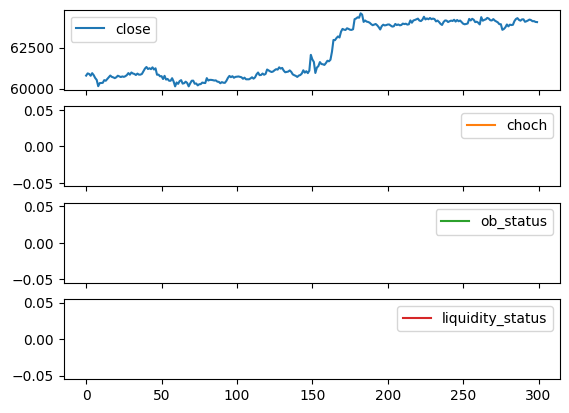

In [144]:
# ohlcv_df = df_candles
# Calculate SMC Indicators
# Split the results into individual columns
fvg_result = smc.fvg(df_candles)
df_candles['fvg_status'] = fvg_result['FVG']  # 1 for bullish FVG, -1 for bearish FVG
df_candles['fvg_top'] = fvg_result['Top']
df_candles['fvg_bottom'] = fvg_result['Bottom']
df_candles['fvg_mitigated'] = fvg_result['MitigatedIndex']

# Similarly for other indicators
swing_hl_result = smc.swing_highs_lows(ohlcv_df)
df_candles['swing_high_low'] = swing_hl_result['HighLow']
df_candles['swing_level'] = swing_hl_result['Level']

bos_choch_result = smc.bos_choch(ohlcv_df, swing_hl_result)
df_candles['bos'] = bos_choch_result['BOS']
df_candles['choch'] = bos_choch_result['CHOCH']
df_candles['structure_level'] = bos_choch_result['Level']

ob_result = smc.ob(ohlcv_df, swing_hl_result)
df_candles['ob_status'] = ob_result['OB']
df_candles['ob_top'] = ob_result['Top']
df_candles['ob_bottom'] = ob_result['Bottom']

liquidity_result = smc.liquidity(ohlcv_df, swing_hl_result)
df_candles['liquidity_status'] = liquidity_result['Liquidity']
df_candles['liquidity_level'] = liquidity_result['Level']


# Backtest logic
cash = 100000  # Starting capital
position = 0  # No position at the start
position_value = 0  # Value of current position
for i in range(1, len(df_candles)):
    # Skip rows where indicators have NaN values
    if pd.isna(df_candles['choch'].iloc[i]) or pd.isna(df_candles['ob_status'].iloc[i]) or pd.isna(df_candles['liquidity_status'].iloc[i]):
        continue  # Skip to the next row if any indicator is NaN
    
    # Long Entry Logic
    if (df_candles['choch'].iloc[i] == 1 and
        df_candles['ob_status'].iloc[i] == 1 and
        df_candles['liquidity_status'].iloc[i] == 1 and
        position == 0):
        position = cash / df_candles['close'].iloc[i]
        cash = 0
        print(f"Buy at {df_candles['close'].iloc[i]}")
    
    # Short Entry Logic
    elif (df_candles['choch'].iloc[i] == -1 and
          df_candles['ob_status'].iloc[i] == -1 and
          df_candles['liquidity_status'].iloc[i] == -1 and
          position == 0):
        position = -cash / df_candles['close'].iloc[i]
        cash = 0
        print(f"Sell at {df_candles['close'].iloc[i]}")


    # Exit logic for long positions
    if position > 0 and ohlcv_df['close'].iloc[i] < ohlcv_df['ob_bottom'].iloc[i]:
        cash = position * ohlcv_df['close'].iloc[i]  # Sell at the close price
        position = 0  # Close the position
        print(f"Exit long at {ohlcv_df['close'].iloc[i]}")

    # Exit logic for short positions
    if position < 0 and ohlcv_df['close'].iloc[i] > ohlcv_df['ob_top'].iloc[i]:
        cash = -position * ohlcv_df['close'].iloc[i]  # Buy back to close the short position
        position = 0  # Close the position
        print(f"Exit short at {ohlcv_df['close'].iloc[i]}")

# Calculate final portfolio value
if position != 0:
    cash += position * ohlcv_df['close'].iloc[-1]  # Close any open positions at the last price

print(f"Final portfolio value: {cash}")

# Plot results (optional)
df_candles[['close', 'choch', 'ob_status', 'liquidity_status']].plot(subplots=True)
plt.show()


In [135]:


# Calculate SMC Indicators
fvg = smc.fvg(df_candles)
swing_hl = smc.swing_highs_lows(df_candles)
bos_choch = smc.bos_choch(df_candles, swing_hl)
order_blocks = smc.ob(df_candles, swing_hl)
liquidity = smc.liquidity(df_candles, swing_hl)
print(fvg)


if bos_choch['CHOCH'].iloc[-1] == 1 and order_blocks['OB'].iloc[-1] == 1 and liquidity['Liquidity'].iloc[-1] == 1:
    print("Enter Long Position")
elif bos_choch['CHOCH'].iloc[-1] == -1 and order_blocks['OB'].iloc[-1] == -1 and liquidity['Liquidity'].iloc[-1] == -1:
    print("Enter Short Position")

     FVG      Top   Bottom  MitigatedIndex
0    NaN      NaN      NaN             NaN
1    NaN      NaN      NaN             NaN
2    NaN      NaN      NaN             NaN
3    NaN      NaN      NaN             NaN
4    NaN      NaN      NaN             NaN
..   ...      ...      ...             ...
295  NaN      NaN      NaN             NaN
296  NaN      NaN      NaN             NaN
297  NaN      NaN      NaN             NaN
298 -1.0  64173.0  64150.0             0.0
299  NaN      NaN      NaN             NaN

[300 rows x 4 columns]


In [126]:

macd_df = ta.macd(df_candles['close'], fast=12, slow=26, signal=9)
df_candles['MACD'] = macd_df['MACD_12_26_9']
df_candles['Signal'] = macd_df['MACDs_12_26_9']
df_candles['RSI'] = ta.rsi(df['close'], length=14)
    
stoch = ta.stoch(df_candles['high'], df_candles['low'], df_candles['close'], k=14, smooth_k=3)
df_candles['stochK'] = stoch['STOCHk_14_3_3']
df_candles['stochD'] = stoch['STOCHd_14_3_3']
df_candles['Volume_Mean'] = df_candles['volume'].rolling(window=30).mean()

# RSI cruzando a linha de 50
rsi_cruzando_50 = df_candles['RSI'].iloc[-2] < 50 and df_candles['RSI'].iloc[-1] > 50
rsi_cruzando_50_baixo = df_candles['RSI'].iloc[-2] > 50 and df_candles['RSI'].iloc[-1] < 50

# MACD dando sinal de compra (MACD cruzando acima da linha de sinal)
macd_compra = df_candles['MACD'].iloc[-2] <= df_candles['Signal'].iloc[-2] and df_candles['MACD'].iloc[-1] > df_candles['Signal'].iloc[-1]
macd_venda = df_candles['MACD'].iloc[-2] >= df_candles['Signal'].iloc[-2] and df_candles['MACD'].iloc[-1] < df_candles['Signal'].iloc[-1]

# Stochastic saindo da região de sobrevenda (abaixo de 35)
stoch_sobrevendido = df_candles['stochK'].iloc[-1] < 35
stoch_sobrecompra = df_candles['stochK'].iloc[-1] > 65

# Volume crescente (volume atual maior que a média móvel do volume)
volume_crescente = df_candles['volume'].iloc[-1] > df_candles['Volume_Mean'].iloc[-1]

# Verificar todas as condições
if rsi_cruzando_50 and macd_compra and stoch_sobrevendido and volume_crescente:
    print("Condições de entrada atendidas: RSI cruzando 50, MACD compra, Stochastic saindo da região de sobrevenda, volume crescente.")
elif rsi_cruzando_50_baixo and macd_venda and stoch_sobrecompra and volume_crescente:
    print("Condições de venda atendidas: RSI cruzando abaixo de 50, MACD venda, Stochastic saindo da região de sobrecompra, volume crescente.")


     STOCHk_14_3_3  STOCHd_14_3_3
13             NaN            NaN
14             NaN            NaN
15       70.913169            NaN
16       69.184017            NaN
17       78.132189      72.743125
..             ...            ...
295      73.175506      75.146717
296      70.095694      71.889448
297      68.310637      70.527279
298      62.703963      67.036764
299      59.281070      63.431890

[287 rows x 2 columns]


In [115]:
# Função para calcular indicadores
def calculate_indicators(df):
    # Calculando o MACD e extraindo suas colunas
    macd_df = ta.macd(df['close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd_df['MACD_12_26_9']
    df['Signal'] = macd_df['MACDs_12_26_9']
    
    # RSI
    df['RSI'] = ta.rsi(df['close'], length=14)
    
    # Bollinger Bands
    bbands = ta.bbands(df['close'], length=20, std=2)
    df['BB_Lower'] = bbands['BBL_20_2.0']
    df['BB_Upper'] = bbands['BBU_20_2.0']
    df['BB_Middle'] = bbands['BBM_20_2.0']
    return df

# Função para gerar sinais de compra e venda
def generate_signals(df):
    df['Buy_Signal'] = (df['MACD'] > df['Signal']) & (df['RSI'] < 50) & (df['close'] < df['BB_Middle'])
    
    # Ajuste: Condição de venda menos restritiva (RSI > 60 em vez de 70)
    df['Sell_Signal'] = (df['RSI'] > 60) & (df['MACD'] < df['Signal'])
    
    # Debugging: Exibir as condições dos sinais
    print(df[['time', 'close', 'MACD', 'Signal', 'RSI', 'BB_Middle', 'Buy_Signal', 'Sell_Signal']].tail(10))
    
    return df

# Função de backtest da estratégia
def backtest_strategy(df, initial_balance=1000, trade_size=0.1):
    balance = initial_balance
    position = 0
    entry_price = 0
    
    for index, row in df.iterrows():
        # Sinal de Compra
        if row['Buy_Signal'] and position == 0:
            position = 1
            entry_price = row['close']
            print(f"Compra em {row['time']} ao preço de {entry_price}")
        
        # Sinal de Venda
        elif row['Sell_Signal'] and position == 1:
            position = 0
            exit_price = row['close']
            profit = (exit_price - entry_price) * trade_size
            balance += profit
            print(f"Venda em {row['time']} ao preço de {exit_price}, Lucro: {profit:.2f}, Saldo: {balance:.2f}")
    
    print(f"Saldo Final: {balance:.2f}")
    return balance

# Função principal
def strategy(symbol, timeframe):
    # df = fetch_market_data(symbol, timeframe, limit)
    df = calculate_indicators(df)
    df = generate_signals(df)
    
    # Executar o backtest
    final_balance = backtest_strategy(df)
    return final_balance

# Executar a estratégia
strategy(symbol, timeframe)

Saldo Final: 1000.00


1000

In [85]:
# Criação do DataFrame
df_candles = pd.DataFrame(bars, columns=['time', 'abertura', 'max', 'min', 'fechamento', 'volume'])

# Converter 'time' para datetime
df_candles['time'] = pd.to_datetime(df_candles['time'], unit='ms', utc=True).map(lambda x: x.tz_convert('America/Sao_Paulo'))
df_candles = df_candles.sort_values(by='time').reset_index(drop=True)

# Calcular indicadores Ichimoku e EMAs
df_candles['EMA_5m'] = ta.ema(df_candles['fechamento'], length=5)
df_candles['EMA_15m'] = ta.ema(df_candles['fechamento'], length=15)
df_candles['EMA_30m'] = ta.ema(df_candles['fechamento'], length=30)
df_candles['EMA_1h'] = ta.ema(df_candles['fechamento'], length=60)
df_candles['EMA_2h'] = ta.ema(df_candles['fechamento'], length=120)

# Calcular o indicador Ichimoku
ichimoku_df, ichimoku_displacement = ta.ichimoku(
    df_candles['max'], df_candles['min'], df_candles['fechamento'], 
    conversion_line_period=9, base_line_periods=26, span_b_periods=52, displacement=26
)

# Renomear colunas de Ichimoku para evitar duplicação
ichimoku_df.columns = [f'{col}_ichimoku' for col in ichimoku_df.columns]

# Adicionar as colunas do Ichimoku ao DataFrame principal
df_candles = pd.concat([df_candles, ichimoku_df], axis=1)

# Calcular ATR
df_candles['ATR'] = ta.atr(df_candles['max'], df_candles['min'], df_candles['fechamento'])

# Função para gerar sinais de compra e venda
def generate_signals(df):
    df['signal'] = 0  # Inicializa sem sinal

    for i in range(1, len(df)):
        # Acessar valores escalares usando .iloc[i] para garantir que estamos acessando um único valor
        fechamento = df['fechamento'].iloc[i]
        isa_9 = df['ISA_9_ichimoku'].iloc[i]
        isb_26 = df['ISB_26_ichimoku'].iloc[i]
        ema_5m = df['EMA_5m'].iloc[i]
        ema_15m = df['EMA_15m'].iloc[i]
        ema_30m = df['EMA_30m'].iloc[i]

        # Verificação de NaN para cada valor individualmente
        if pd.isna(fechamento) or pd.isna(isa_9) or pd.isna(isb_26) or pd.isna(ema_5m) or pd.isna(ema_15m) or pd.isna(ema_30m):
            continue  # Pula para o próximo loop se houver NaN

        # Condição de Compra
        if fechamento > isa_9 and fechamento > isb_26 and ema_5m > ema_15m and ema_15m > ema_30m:
            df.loc[i, 'signal'] = 1  # Sinal de compra

        # Condição de Venda
        elif fechamento < ema_5m:
            df.loc[i, 'signal'] = -1  # Sinal de venda

    return df

# Aplicar a função para gerar sinais
df_candles = generate_signals(df_candles)
last_row = df_candles.iloc[-1]
print(last_row)
# # Função para executar o backtest
# def backtest_strategy(df, tp_percentage=1.5, sl_percentage=-1):
#     trade_log = []
#     position = None
#     entry_price = 0

#     for i in range(len(df)):
#         if df['signal'].iloc[i] == 1 and position is None:
#             position = 'long'
#             entry_price = df['fechamento'].iloc[i]
#             trade_log.append(('buy', entry_price, 'entry'))

#         elif df['signal'].iloc[i] == -1 and position == 'long':
#             exit_price = df['fechamento'].iloc[i]
#             profit = exit_price - entry_price
#             if profit / entry_price * 100 >= tp_percentage:
#                 trade_log.append(('sell', profit, 'take_profit'))
#             elif profit / entry_price * 100 <= sl_percentage:
#                 trade_log.append(('sell', profit, 'stop_loss'))
#             position = None

#     return trade_log

# # Executando o backtest
# trade_log = backtest_strategy(df_candles)

# # Função para analisar a performance
# def analyze_performance(trade_log):
#     wins = [trade for trade in trade_log if trade[2] == 'take_profit']
#     losses = [trade for trade in trade_log if trade[2] == 'stop_loss']
    
#     win_rate = len(wins) / (len(wins) + len(losses)) * 100 if (len(wins) + len(losses)) > 0 else 0
#     total_profit = sum([trade[1] for trade in wins])
#     total_loss = sum([trade[1] for trade in losses])
    
#     print(f"Total de Trades: {len(wins) + len(losses)}")
#     print(f"Taxa de Acerto: {win_rate:.2f}%")
#     print(f"Lucro Total: {total_profit}")
#     print(f"Perda Total: {total_loss}")

# # Analisando a performance
# analyze_performance(trade_log)


time               2024-08-21 19:25:00-03:00
abertura                             61266.9
max                                  61338.0
min                                  61259.1
fechamento                           61333.0
volume                               154.214
EMA_5m                          61294.572266
EMA_15m                         61251.972147
EMA_30m                         61164.248811
EMA_1h                          60889.199468
EMA_2h                          60450.772582
ISA_9_ichimoku                      61153.25
ISB_26_ichimoku                      60566.9
ITS_9_ichimoku                       61239.4
IKS_26_ichimoku                      61191.1
ICS_26_ichimoku                          NaN
ATR                               150.232367
signal                                     1
Name: 299, dtype: object


In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from scipy.signal import find_peaks

# Supondo que 'df_candles' seja o DataFrame com os dados de candles
# df_candles = pd.DataFrame(bars, columns=['time', 'abertura', 'max', 'min', 'fechamento', 'volume'])

# Função para detectar o padrão OCO (Ombro Cabeça Ombro)
def detectar_oco(df, distancia_minima=5):
    peaks, _ = find_peaks(df['fechamento'], distance=distancia_minima)
    oco_detectado = []
    
    for i in range(1, len(peaks) - 1):
        ombro_esq = df['fechamento'][peaks[i - 1]]
        cabeca = df['fechamento'][peaks[i]]
        ombro_dir = df['fechamento'][peaks[i + 1]]
        
        if ombro_esq < cabeca and ombro_dir < cabeca and abs(ombro_esq - ombro_dir) < 0.05 * cabeca:
            oco_detectado.append((peaks[i - 1], peaks[i], peaks[i + 1]))
    
    return oco_detectado


# Função para detectar padrões de triângulo e cunha
def detectar_triangulos_cunhas(df, periodo=20):
    # Calcular suportes e resistências usando linhas de tendência
    df['suporte'] = df['min'].rolling(window=periodo).min()
    df['resistencia'] = df['max'].rolling(window=periodo).max()

    convergencias = []
    for i in range(periodo, len(df)):
        if df['resistencia'].iloc[i] < df['resistencia'].iloc[i - periodo] and df['suporte'].iloc[i] > df['suporte'].iloc[i - periodo]:
            convergencias.append(i)
    
    return convergencias

# Função para detectar padrões de bandeiras
def detectar_bandeiras(df, periodo=10, threshold=1.5):
    # Calcular o range do preço para identificar movimentos fortes
    df['range'] = df['max'] - df['min']
    movimentos_fortes = df[df['range'] > threshold * df['range'].rolling(window=periodo).mean()]

    bandeiras = []
    for i in range(1, len(movimentos_fortes)):
        inicio = movimentos_fortes.index[i - 1]
        fim = movimentos_fortes.index[i]
        
        if fim - inicio < periodo:
            bandeiras.append((inicio, fim))
    
    return bandeiras

# Exemplo de uso com df_candles
oco_padroes = detectar_oco(df_candles)
triangulos_cunhas = detectar_triangulos_cunhas(df_candles)
bandeiras = detectar_bandeiras(df_candles)

print(f"Padrões OCO detectados: {oco_padroes}")
print(f"Padrões de Triângulos/Cunhas detectados: {triangulos_cunhas}")
print(f"Padrões de Bandeiras detectados: {bandeiras}")


# Supondo que os padrões já tenham sido detectados com as funções anteriores
# e que temos os pontos de rompimento.
# Função para realizar entradas baseadas nos padrões detectados
def realizar_entradas(df, oco_padroes, triangulos_cunhas, bandeiras, stop_loss_pct=0.02, take_profit_pct=0.04):
    sinais_de_compra = []
    sinais_de_venda = []

    # Prioridade: OCO > Triângulos/Cunhas > Bandeiras
    # Usaremos uma variável de controle para evitar sinais conflitantes
    sinal_gerado = False

    # 1. Prioridade para OCO
    if oco_padroes and not sinal_gerado:
        ombro_esq, cabeca, ombro_dir = oco_padroes[-1]
        linha_pescoco = (df['fechamento'][ombro_esq] + df['fechamento'][ombro_dir]) / 2
        if df['fechamento'].iloc[-1] < linha_pescoco:
            sinais_de_venda.append({
                'index': df.index[-1],
                'preco_entrada': df['fechamento'].iloc[-1],
                'stop_loss': df['fechamento'].iloc[-1] * (1 + stop_loss_pct),
                'take_profit': df['fechamento'].iloc[-1] * (1 - take_profit_pct)
            })
            sinal_gerado = True

    # 2. Triângulos e Cunhas
    if triangulos_cunhas and not sinal_gerado:
        idx = triangulos_cunhas[-1]
        resistencia = df['resistencia'].iloc[idx]
        suporte = df['suporte'].iloc[idx]
        
        if df['fechamento'].iloc[-1] > resistencia:
            sinais_de_compra.append({
                'index': df.index[-1],
                'preco_entrada': df['fechamento'].iloc[-1],
                'stop_loss': df['fechamento'].iloc[-1] * (1 - stop_loss_pct),
                'take_profit': df['fechamento'].iloc[-1] * (1 + take_profit_pct)
            })
            sinal_gerado = True
        elif df['fechamento'].iloc[-1] < suporte:
            sinais_de_venda.append({
                'index': df.index[-1],
                'preco_entrada': df['fechamento'].iloc[-1],
                'stop_loss': df['fechamento'].iloc[-1] * (1 + stop_loss_pct),
                'take_profit': df['fechamento'].iloc[-1] * (1 - take_profit_pct)
            })
            sinal_gerado = True

    # 3. Bandeiras
    if bandeiras and not sinal_gerado:
        inicio, fim = bandeiras[-1]
        range_bandeira = df.loc[inicio:fim, 'fechamento']
        if df['fechamento'].iloc[-1] > range_bandeira.max():
            sinais_de_compra.append({
                'index': df.index[-1],
                'preco_entrada': df['fechamento'].iloc[-1],
                'stop_loss': df['fechamento'].iloc[-1] * (1 - stop_loss_pct),
                'take_profit': df['fechamento'].iloc[-1] * (1 + take_profit_pct)
            })
        elif df['fechamento'].iloc[-1] < range_bandeira.min():
            sinais_de_venda.append({
                'index': df.index[-1],
                'preco_entrada': df['fechamento'].iloc[-1],
                'stop_loss': df['fechamento'].iloc[-1] * (1 + stop_loss_pct),
                'take_profit': df['fechamento'].iloc[-1] * (1 - take_profit_pct)
            })

    return sinais_de_compra, sinais_de_venda

# Exemplo de uso
sinais_compra, sinais_venda = realizar_entradas(df_candles, oco_padroes, triangulos_cunhas, bandeiras)

print(f"Sinais de Compra: {sinais_compra}")
print(f"Sinais de Venda: {sinais_venda}")

import matplotlib.pyplot as plt
import pandas as pd

# Supondo que df_candles seja o DataFrame com os dados de candles
# df_candles = pd.DataFrame(bars, columns=['time', 'abertura', 'max', 'min', 'fechamento', 'volume'])

# Função para plotar o gráfico com padrões e entradas
def plotar_grafico(df_candles, oco_padroes, triangulos_cunhas, bandeiras, sinais_compra, sinais_venda):
    plt.figure(figsize=(14, 7))
    
    # Plotando o gráfico de velas
    plt.plot(df_candles['time'], df_candles['fechamento'], label='Fechamento', color='blue')
    
    # Plotando padrões OCO
    for oco in oco_padroes:
        ombro_esq_idx, cabeca_idx, ombro_dir_idx = oco
        plt.plot([df_candles['time'].iloc[ombro_esq_idx], df_candles['time'].iloc[cabeca_idx], df_candles['time'].iloc[ombro_dir_idx]], 
                 [df_candles['fechamento'].iloc[ombro_esq_idx], df_candles['fechamento'].iloc[cabeca_idx], df_candles['fechamento'].iloc[ombro_dir_idx]], 
                 color='purple', label='Padrão OCO')

    # Plotando padrões de Triângulos/Cunhas
    for idx in triangulos_cunhas:
        plt.axvline(x=df_candles['time'].iloc[idx], color='orange', linestyle='--', label='Triângulo/Cunha')

    # Plotando padrões de Bandeiras
    for bandeira in bandeiras:
        inicio_idx, fim_idx = bandeira
        plt.plot(df_candles['time'].iloc[inicio_idx:fim_idx], df_candles['fechamento'].iloc[inicio_idx:fim_idx], 
                 color='green', linestyle='--', label='Bandeira')

    # Plotando as entradas de compra
    for sinal in sinais_compra:
        plt.scatter(df_candles['time'].iloc[sinal['index']], sinal['preco_entrada'], color='green', label='Compra', marker='^', s=100)
    
    # Plotando as entradas de venda
    for sinal in sinais_venda:
        plt.scatter(df_candles['time'].iloc[sinal['index']], sinal['preco_entrada'], color='red', label='Venda', marker='v', s=100)
    
    plt.title('Entradas e Padrões Gráficos')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.grid(True)
    plt.show()

# Supondo que temos os dados do df_candles e os padrões detectados
# oco_padroes = detectar_oco(df_candles)
# triangulos_cunhas = detectar_triangulos_cunhas(df_candles)
# bandeiras = detectar_bandeiras(df_candles)

# Exemplo de uso com dados fictícios
# plotar_grafico(df_candles, oco_padroes, triangulos_cunhas, bandeiras, sinais_compra, sinais_venda)

In [ ]:
import pandas as pd
import numpy as np
import logging

# Configuração básica de logging
logging.basicConfig(level=logging.INFO)

# Função para calcular os componentes da Nuvem de Ichimoku com configurações cripto
def ichimoku_cloud(df, tenkan=20, kijun=30, senkou_b=120, displacement=60):
    df['tenkan_sen'] = (df['max'].rolling(window=tenkan).max() + df['min'].rolling(window=tenkan).min()) / 2
    df['kijun_sen'] = (df['max'].rolling(window=kijun).max() + df['min'].rolling(window=kijun).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = (df['max'].rolling(window=senkou_b).max() + df['min'].rolling(window=senkou_b).min()) / 2
    df['senkou_span_b'] = df['senkou_span_b'].shift(displacement)
    df['chikou_span'] = df['fechamento'].shift(-displacement)
    return df

# Função para definir a lógica da estratégia com cruzamento de Tenkan e Kijun
def strategy(df):
    df['signal'] = 0  # Nenhuma posição por padrão

    # Sinal de Compra: Cruzamento da linha Tenkan acima da linha Kijun e preço acima da nuvem
    df.loc[(df['tenkan_sen'] > df['kijun_sen']) & (df['fechamento'] > df['senkou_span_a']) & (df['fechamento'] > df['senkou_span_b']), 'signal'] = 1

    # Sinal de Venda: Cruzamento da linha Tenkan abaixo da linha Kijun e preço abaixo da nuvem
    df.loc[(df['tenkan_sen'] < df['kijun_sen']) & (df['fechamento'] < df['senkou_span_a']) & (df['fechamento'] < df['senkou_span_b']), 'signal'] = -1

    return df

def execute_last_order(df, stop_loss_pct=0.05, take_profit_pct=0.10):
    last_row = df.iloc[-1]  # Pega a última linha do DataFrame
    
    # Depuração: imprimir a última linha para verificar os valores
    print("Última linha do DataFrame:\n", last_row)
    
    if last_row['signal'] == 1:  # Sinal de Compra
        stop_loss = last_row['fechamento'] * (1 - stop_loss_pct)
        take_profit = last_row['fechamento'] * (1 + take_profit_pct)
        logging.info(f"Comprar em {last_row['time']} ao preço {last_row['fechamento']}, Stop Loss: {stop_loss}, Take Profit: {take_profit}")
        # Insira aqui o código para enviar uma ordem de compra com stop loss e take profit
    
    elif last_row['signal'] == -1:  # Sinal de Venda
        stop_loss = last_row['fechamento'] * (1 + stop_loss_pct)
        take_profit = last_row['fechamento'] * (1 - take_profit_pct)
        logging.info(f"Vender em {last_row['time']} ao preço {last_row['fechamento']}, Stop Loss: {stop_loss}, Take Profit: {take_profit}")
        # Insira aqui o código para enviar uma ordem de venda com stop loss e take profit

# Exemplo de como usar no seu bot
def run_bot(df):
    # Calcular os indicadores da nuvem de Ichimoku com configurações ajustadas para cripto
    df = ichimoku_cloud(df)

    # Aplicar a estratégia para gerar sinais de compra e venda
    df = strategy(df)

    # Executar ordens com gestão de risco
    execute_last_order(df)

# Supondo que o df_candles foi inicializado corretamente com os dados
run_bot(df_candles)


In [ ]:
import pandas as pd
import logging

# Configuração de logging detalhado
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Função para identificar topos e fundos válidos e CHoCH
def identifica_estrutura_mercado(df):
    df['topo_valido'] = False
    df['fundo_valido'] = False
    df['choch'] = False
    df['buy_signal'] = False
    df['sell_signal'] = False
    
    last_valid_high = None
    last_valid_low = None
    is_bullish_trend = None  # None, True, False

    for i in range(2, len(df)):
        current_high = df['max'].iloc[i]
        current_low = df['min'].iloc[i]
        
        # Identificando topos válidos
        if current_high > df['max'].iloc[i-1] and df['min'].iloc[i-1] < df['min'].iloc[i-2]:
            df.at[i, 'topo_valido'] = True
            last_valid_high = current_high
            # logger.info(f"Novo topo válido detectado em {df['time'].iloc[i]}: {last_valid_high}")
        
        # Identificando fundos válidos
        if current_low < df['min'].iloc[i-1] and df['max'].iloc[i-1] > df['max'].iloc[i-2]:
            df.at[i, 'fundo_valido'] = True
            last_valid_low = current_low
            # logger.info(f"Novo fundo válido detectado em {df['time'].iloc[i]}: {last_valid_low}")
        
        # Detectando CHoCH (mudança de estrutura)
        if last_valid_high is not None and last_valid_low is not None:
            if current_low < last_valid_low and is_bullish_trend != False:
                df.at[i, 'choch'] = True
                df.at[i, 'sell_signal'] = True  # Gerar sinal de venda após CHoCH Bearish
                is_bullish_trend = False
                last_valid_low = current_low
                # logger.info(f"CHoCH Bearish detectado em {df['time'].iloc[i]}: rompimento do fundo válido {last_valid_low}")
            
            elif current_high > last_valid_high and is_bullish_trend != True:
                df.at[i, 'choch'] = True
                df.at[i, 'buy_signal'] = True  # Gerar sinal de compra após CHoCH Bullish
                is_bullish_trend = True
                last_valid_high = current_high
                # logger.info(f"CHoCH Bullish detectado em {df['time'].iloc[i]}: rompimento do topo válido {last_valid_high}")
    
    return df

# Função principal da estratégia SMC
def smc_strategy(df):
    df = identifica_estrutura_mercado(df)
    return df

# Exemplo de uso com o DataFrame df_candles
df_candles = smc_strategy(df_candles)

# Exibe os sinais gerados
print(df_candles[['time', 'fechamento', 'choch', 'buy_signal', 'sell_signal']])


In [ ]:
# import logger
# Função para o indicador G-Channel
def g_channel(df, length=100):
    df['a'] = (df['fechamento'].rolling(length).max() - df['fechamento'].shift(1)) / length
    df['b'] = (df['fechamento'].rolling(length).min() + df['fechamento'].shift(1)) / length
    df['avg'] = (df['a'] + df['b']) / 2
    
    # Cruzamentos
    df['crossup'] = (df['b'].shift(1) > df['fechamento'].shift(1)) & (df['b'] < df['fechamento'])
    df['crossdn'] = (df['a'].shift(1) > df['fechamento'].shift(1)) & (df['a'] < df['fechamento'])
    
    # Condição de alta (bullish)
    df['bullish'] = (df['crossdn'].cumsum() <= df['crossup'].cumsum())
    
    return df

def g_ema_strategy(df, g_channel_length=100, ema_length=50):
    df = g_channel(df, length=g_channel_length)
    df['ema'] = ta.ema(df['fechamento'], length=ema_length)
    
    # Sinal de compra apenas se o mercado está "bullish"
    df['buy_signal'] = (df['bullish']) & (df['fechamento'] > df['ema']) & df['crossup']
    
    # Sinal de venda apenas se o mercado está "bearish"
    df['sell_signal'] = (~df['bullish']) & (df['fechamento'] < df['ema']) & df['crossdn']
    
    return df

# Exemplo de uso com o seu DataFrame df_candles
df_candles = g_ema_strategy(df_candles)

# Exibe o DataFrame com os sinais gerados
print(df_candles[['time', 'fechamento', 'ema', 'bullish', 'buy_signal', 'sell_signal']])
# print(f"Fechamento: {last_row['fechamento']}, EMA: {last_row['ema']}, Crossup: {last_row['crossup']}, Crossdn: {last_row['crossdn']}")



In [ ]:
import pandas as pd

def backtest_strategy(df):
    capital_inicial = 10000  # Capital inicial em USDT
    capital = capital_inicial
    posicao = 0
    entrada = 0
    operacoes = []

    for index, row in df.iterrows():
        # Sinal de compra
        if row['buy_signal'] and posicao == 0:
            posicao = capital / row['fechamento']  # Compramos o máximo possível com o capital atual
            entrada = row['fechamento']
            capital = 0  # Todo o capital foi investido
            operacoes.append(f"Compra em {row['time']} a {row['fechamento']}")

        # Sinal de venda
        elif row['sell_signal'] and posicao > 0:
            capital = posicao * row['fechamento']  # Vendemos a posição
            lucro = capital - (posicao * entrada)  # Calcula o lucro ou prejuízo
            operacoes.append(f"Venda em {row['time']} a {row['fechamento']} com lucro/prejuízo de {lucro:.2f}")
            posicao = 0  # Fechamos a posição

    # Se a posição ainda estiver aberta no final do período de backtest, fechamos a posição
    if posicao > 0:
        capital = posicao * df.iloc[-1]['fechamento']
        lucro = capital - (posicao * entrada)
        operacoes.append(f"Fechamento final da posição em {df.iloc[-1]['time']} a {df.iloc[-1]['fechamento']} com lucro/prejuízo de {lucro:.2f}")
    
    retorno_total = capital - capital_inicial
    return operacoes, retorno_total

# Exemplo de DataFrame com sinais gerados anteriormente
# df_candles é o DataFrame que contém as colunas ['time', 'fechamento', 'buy_signal', 'sell_signal']

# Executa o backtest
operacoes, retorno_total = backtest_strategy(df_candles)

# Exibe os resultados do backtest
for operacao in operacoes:
    print(operacao)

print(f"Retorno total do backtest: {retorno_total:.2f} USDT")


In [ ]:
# df_candles['SMA_200'] = ta.sma(close = df_candles['fechamento'], length=200)
# df_candles['EMA_12'] = ta.ema(close = df_candles.fechamento, length=12)
df_candles['EMA_26'] = ta.ema(close = df_candles['fechamento'], length=26)
rsi = RSIIndicator(df_candles['fechamento'])
df_candles['RSI'] = rsi.rsi()
df_candles['sup100'] = df_candles['min'].rolling(window=100).min()
df_candles['sup50'] = df_candles['min'].rolling(window=60).min()
print(f"SUP 60 {df_candles['sup50'].iloc[-1]}")
print(f"SUP 100 {df_candles['sup100'].iloc[-1]}")
print(f"fechamento {df_candles['fechamento'].iloc[-1]}")


In [ ]:



# smas = [12, 26]

# for sma in smas:
#     df_candles[f'SMA_{sma}'] = df_candles['fechamento'].rolling(sma).mean()

df_candles['SMA_200'] = ta.sma(close = df_candles.fechamento, length=200)
df_candles['EMA_12'] = ta.ema(close = df_candles.fechamento, length=12)
df_candles['EMA_26'] = ta.ema(close = df_candles.fechamento, length=26)
# df_candles['VOL'] = df_candles.volume.iloc[-1]
# vol = VolumePriceTrendIndicator(close=df_candles.fechamento, volume=df_candles.volume, smoothing_factor=20)
# df_candles['VOL'] = vol

# df_candles[['fechamento','SMA_200', 'EMA_12', 'EMA_26','VOL', 'VOL2']][400:500].plot() 

# print(df_candles['VOL'])




In [ ]:
# df_candles[['fechamento','SMA_200', 'EMA_12', 'EMA_26']][200:500].plot() 
rsi = RSIIndicator(df_candles['fechamento'])



In [ ]:
bbands = ta.bbands(df_candles.fechamento, lenght = 20, sdt=2)

In [ ]:
# rsi = RSIIndicator(df_candles['fechamento'])
bbands = bbands.iloc[:,[0,1,2]]
bbands.columns = ['BBL', 'BBM', 'BBU']
# df_candles = pd.concat([df_candles, bbands], axis=1)
df_candles['RSI'] = rsi.rsi()
df_candles = pd.concat([df_candles, bbands], axis=1)
# df_candles
# df_candles.tail()

# df_candles['BBU'].iloc[-1].max()

vpt = VolumePriceTrendIndicator(close=df_candles['fechamento'], volume=df_candles['volume']) 
df_candles['VPT'] = vpt.volume_price_trend()
df_candles.tail()


if df_candles['VPT'].iloc[-1] > df_candles['VPT'].iloc[-2]:
    print('alta')
# Verifica se a posição atual é menor que a de 3 velas atrás, indicando baixa
elif df_candles['VPT'].iloc[-1] < df_candles['VPT'].iloc[-2]:
    print('baixa')
else:
    print('sem mudança significativa')




# print(f"'df_candles: = ' {df_candles['BBU']"})

# df_candles['fechamento'].iloc[-1]
# df_candles['fechamento'].iloc[-1]

# volumeA = df_candles['volume'].iloc[-1]
# volumeB = df_candles['volume'].iloc[1]


# volumeA = pd.concat([volumeA, volumeB], axis=1)
# volumeA

# print(f"{volumeA}-{df_candles['time'].iloc[-1]} , {volumeB}-{df_candles['time'].iloc[-1]}")




# if volumeA > volumeB :
#     print('posso comprar')
# else : 
#     print('nao posso comprar')

# if df_candles['fechamento'].iloc[-1] >= df_candles['BBU'].iloc[-1].max() and df_candles['RSI'] >= 71:
#     if df_candles['VPT'].iloc[-1] < df_candles['VPT'].iloc[-4]:
#         print('vendinha')
# elif df_candles['fechamento'].iloc[-1] <= df_candles['BBL'].iloc[-1].max() and df_candles['RSI'] <= 29:    
#     if df_candles['VPT'].iloc[-1] > df_candles['VPT'].iloc[-4]:
#         print('compra')
# else:
#     print('nada pra fazer')     
